## Analysis sparks multiple images

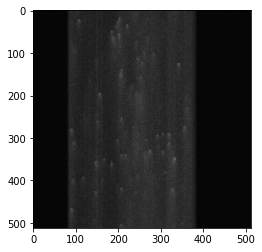

Continue? n


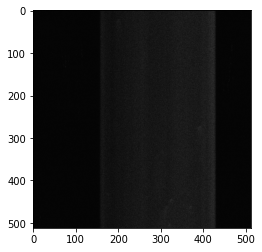

KeyboardInterrupt: Interrupted by user

In [5]:
from os import listdir
from os.path import isfile, join
from sparks_image import *
from sparks_analysis import *
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


path = '/home/leandro/sp_para entrenar/'
files = [".".join(f.split(".")[:-1]) for f in listdir(path) if isfile(join(path, f))]
for photo_name in files:
    image = cv2.imread(path + photo_name + ".tif")    # Read image
    plt.imshow(image, cmap='gray')
    plt.show()
    cont = input('Continue?')
    if 's' in cont.lower():
        list_img = image_process (image,path,5)
        list_img_col = list_img [0]
        list_img_row = list_img [1]
        x = list_img[2]
        y = list_img[3]
        width = list_img[4]
        high = list_img[5]
        out_sparks = analysis_process (list_img_col, list_img_row,x,y,width,high)
        print (out_sparks)
#         pd.DataFrame.to_csv(out_sparks,path+photo_name)

In [1]:
# Define the function to be called on mouse click
def on_click(event, x, y, flags, param):
    # Check if the mouse was actually clicked
    if event == cv2.EVENT_LBUTTONDOWN:
        # Do something
        cv2.destroyAllWindows()

def paint_canvas():
    winname="Paint :: Press ESC to exit; Double Click to TAG"
    cv2.namedWindow(winname)
    cv2.setMouseCallback(winname,on_click)
    while(1):
        cv2.imshow(winname,img)
        if cv2.waitKey(20) & 0xFF ==27:
            break
    cv2.destroyAllWindows()

In [7]:
img = cv2.imread(path + photo_name + ".tif") 

NameError: name 'draw_text' is not defined

## Sparks analysis single image

In [ ]:
from sparks_image import *
from sparks_analysis import *
import cv2
from scipy import stats

path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Sp/Imagenes_confocal/Rata/C071112/'
photo_name = 'c2ac009'
image = cv2.imread(path + photo_name + ".tif")    # Read image
list_img = image_process (image,path,8)
if list_img:
    list_img_col = list_img [0]
    list_img_row = list_img [1]
    out_sparks = analysis_process (list_img_col, list_img_row)

In [ ]:
out_sparks

from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

img_bc = interactive(f, brightness=100, contrast=100)   #display brightness and contrast
display (img_bc)

im = rotation (imCrop, 90)    # rotate image
display_image ('Image' , im)    # Display cropped image